In [2]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,accuracy_score,classification_report
import skfuzzy as fuzz
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pandas
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [3]:
# torch-only correlation with score for BordeauxWines.csv

# ---------- config ----------
CSV_PATH = "BordeauxWines.csv"
SCORE_CANDIDATES = ["score","Score","quality","Quality","rating","Rating","points","Points"]
ADD_SQUARED_FEATURES = False      # set True if you want x^2 columns like the slide
SAVE_CSV = True
TOP_K = 30                        # top 60 features by absolute correlation

# ---------- load & prepare ----------
df = pd.read_csv(CSV_PATH)

# keep numeric columns
df_num = df.select_dtypes(include=[np.number]).copy()

# choose or create a score column
score_col = next((c for c in SCORE_CANDIDATES if c in df_num.columns), None)
if score_col is None:
    score_col = "total_score"
    df_num[score_col] = df_num.dropna(axis=1).fillna(0.0).sum(axis=1)

# X features (drop target), y target
X_df = df_num.drop(columns=[score_col]).fillna(0.0)
y_df = df_num[score_col].astype(float)

# (optional) add squared terms like x^2
if ADD_SQUARED_FEATURES:
    X_sq = X_df ** 2
    X_sq.columns = [f"{c}^2" for c in X_sq.columns]
    X_df = pd.concat([X_df, X_sq], axis=1)

# convert to torch
device = "cuda" if torch.cuda.is_available() else "cpu"
X = torch.tensor(X_df.values, dtype=torch.float32, device=device)
y = torch.tensor(y_df.values, dtype=torch.float32, device=device).view(-1, 1)

# ---------- pearson correlation (torch) ----------
# center
Xc = X - X.mean(dim=0, keepdim=True)
yc = y - y.mean(dim=0, keepdim=True)

# std with epsilon to avoid /0
eps = 1e-12
Xstd = Xc.pow(2).sum(dim=0).div(X.shape[0]-1).sqrt().clamp_min(eps)  # (d,)
ystd = yc.pow(2).sum(dim=0).div(X.shape[0]-1).sqrt().clamp_min(eps)  # (1,)

# covariance between each feature and y
cov_xy = (Xc * yc).sum(dim=0).div(X.shape[0]-1)                      # (d,)

# correlation for each feature with y
corr_xy = cov_xy / (Xstd * ystd.squeeze())                           # (d,)

# move back to cpu + pandas
corr_series = pd.Series(corr_xy.detach().cpu().numpy(), index=X_df.columns, name=f"corr_with_{score_col}")

# ---------- top features by absolute correlation ----------
corr_abs_sorted = corr_series.abs().sort_values(ascending=False)
top_features = corr_abs_sorted.head(TOP_K)
top_features_values = corr_series[top_features.index]  # keep original sign

# add label column for positive/negative
top_features_df = pd.DataFrame({
    "correlation": top_features_values,
    "sign": ["positive" if v >= 0 else "negative" for v in top_features_values]
})

# ---------- outputs ----------
print(f"\nTop {TOP_K} features by absolute correlation with {score_col}:\n")
print(top_features_df)

if SAVE_CSV:
    out_path = "feature_score_correlation_torch_top60.csv"
    top_features_df.to_csv(out_path, header=True)
    print(f"\nSaved top {TOP_K} features to: {out_path}")

# ---------- (optional) full correlation matrix in torch ----------
# If you ever need the full (features + y) correlation matrix like the slide:
# Stack y as the last column and compute all-by-all correlations in one go.

def full_corrcoef_torch(M: torch.Tensor, eps: float = 1e-12) -> torch.Tensor:
    """
    M: (n_samples, n_vars). Returns (n_vars, n_vars) Pearson correlation matrix.
    """
    Mc = M - M.mean(dim=0, keepdim=True)
    std = Mc.pow(2).sum(dim=0).div(M.shape[0]-1).sqrt().clamp_min(eps)  # (v,)
    cov = Mc.T @ Mc / (M.shape[0]-1)                                     # (v, v)
    corr = cov / (std[:, None] * std[None, :])
    return corr

# Example usage:
# M = torch.cat([X, y], dim=1)              # (n, d+1)
# C = full_corrcoef_torch(M).cpu().numpy()  # full matrix like the slide
# # last column/row corresponds to y



Top 30 features by absolute correlation with Score:

               correlation      sign
GREAT             0.335469  positive
LONG              0.317780  positive
MEDIUM-BODIED    -0.272295  negative
CHARACTER        -0.244106  negative
LIGHT-BODIED     -0.232344  negative
FULL-BODIED       0.221209  positive
BLACKBERRY        0.219325  positive
FIG               0.214505  positive
HERBS            -0.214154  negative
BLACK CURRANT     0.195338  positive
BEAUTY            0.192052  positive
Year              0.189012  positive
BERRY            -0.178139  negative
POWER             0.172462  positive
DENSE             0.170415  positive
PENCIL LEAD       0.168566  positive
WARM              0.167754  positive
APPLE             0.167546  positive
FLAVORS           0.167008  positive
LOVELY            0.166112  positive
RICH              0.164799  positive
GORGEOUS          0.164512  positive
MODEST           -0.163695  negative
PURE              0.160996  positive
BOYSENBERRY       0.1

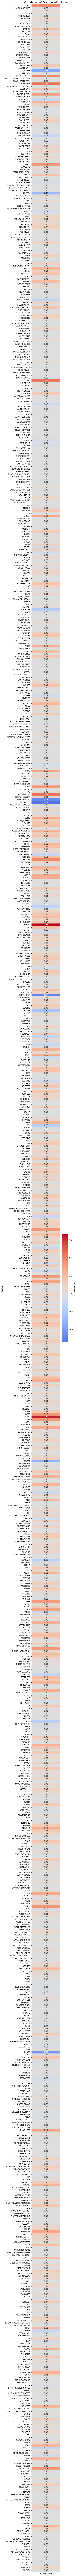

In [4]:
# --- if you just ran the previous correlation code, corr_series already exists ---
plt.figure(figsize=(6, max(6, len(corr_series)/5)))  # auto height for many features
sns.heatmap(
    corr_series.to_frame(),      # convert to DataFrame for sns.heatmap
    annot=True, fmt=".2f",
    cmap="coolwarm", center=0,
    cbar_kws={'label': 'Correlation'},
)
plt.title(f"Correlation of Features with {score_col}", fontsize=14)
plt.xlabel("")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [5]:
#defining features and target
feature_list = top_features.index.tolist()

score_col = "total_score"
if "Score" in df.columns: score_col = "Score"
elif "score" in df.columns: score_col = "score"
else: df[score_col] = df[feature_list].sum(axis=1) 
df_filtered = df[feature_list + [score_col]] 
df_filtered.to_csv("BordeauxWines_top30.csv",index=False)

X = df_filtered[feature_list].to_numpy(dtype=np.float64) 
y = df_filtered[score_col].to_numpy(dtype=np.float64)

#train and testing
test_size=0.2
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=42)


In [6]:
scaler=StandardScaler()
Xtr= scaler.fit_transform(Xtr)
Xte= scaler.transform(Xte)


GK done: N=14349, P=30, clusters=7, FPC=0.506
Cluster sizes: [1914 5350 2332  138 2300   88 2227]

Score by GK cluster:
                mean  median  count
GK_Label                          
0.0       91.341170    91.0   1914
2.0       88.687822    88.0   2332
1.0       88.405981    88.0   5350
3.0       86.963768    87.0    138
5.0       86.079545    87.0     88
4.0       85.841739    86.0   2300
6.0       84.472833    85.0   2227


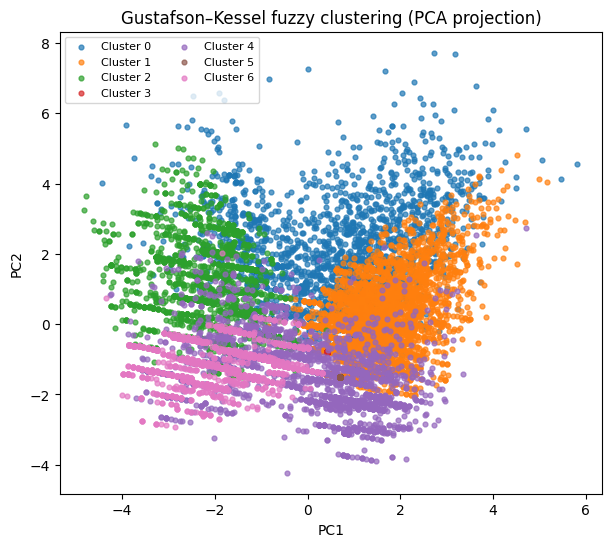

In [7]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# === 0) Data: pick valid rows and standardize ===
feature_cols = feature_list
X_src = df[feature_cols]
mask = X_src.notnull().all(axis=1) & np.isfinite(X_src.values).all(axis=1)
idx = X_src.index[mask]
X = StandardScaler().fit_transform(X_src.loc[idx].values)  # GK works best with scaled data
N, P = X.shape

# === 1) GK (Gustafson–Kessel) fuzzy clustering ===
def gk_fuzzy(X, c, m=2.0, maxiter=200, tol=1e-5, reg=1e-6, random_state=42):
    """
    X: (N,P) standardized data
    c: number of clusters
    m: fuzzifier (>1)
    Returns: centers (c,P), memberships U (c,N), covariances list length c, distances (c,N), fpc
    """
    rng = np.random.default_rng(random_state)
    N, P = X.shape

    # init memberships uniformly at random then normalize columns
    U = rng.random((c, N)) + 1e-8
    U /= U.sum(axis=0, keepdims=True)

    prev_U = U.copy()
    for it in range(maxiter):
        Um = U ** m                                     # (c,N)

        # centers v_k
        denom = Um.sum(axis=1, keepdims=True)          # (c,1)
        V = (Um @ X) / denom                            # (c,P)

        # covariances C_k and adaptive metric A_k
        A_list, C_list = [], []
        for k in range(c):
            diff = X - V[k]                             # (N,P)
            # weighted covariance
            Sk = (Um[k][:, None] * diff).T @ diff / denom[k, 0]   # (P,P)
            # regularize for stability
            Sk += reg * np.eye(P)
            # GK uses A_k = det(Sk)^(1/P) * inv(Sk)  (volume constraint det(A_k)=1)
            det = np.linalg.det(Sk)
            det = max(det, 1e-12)
            Ak = (det ** (1.0 / P)) * np.linalg.inv(Sk)
            A_list.append(Ak)
            C_list.append(Sk)

        # distances d_{ki}^2 = (x_i - v_k)^T A_k (x_i - v_k)
        D = np.empty((c, N))
        for k in range(c):
            diff = X - V[k]
            D[k] = np.einsum('ij,ij->i', diff @ A_list[k], diff) + 1e-12  # avoid zeros

        # update memberships
        # handle exact zeros by hard-assigning those points to the closest cluster
        zero_mask = (D <= 1e-20)
        if zero_mask.any():
            U[:] = 0.0
            closest = np.argmin(D, axis=0)
            U[closest, np.arange(N)] = 1.0
        else:
            power = 1.0 / (m - 1.0)
            inv = D ** (-power)                 # (c,N)
            U = inv / inv.sum(axis=0, keepdims=True)

        # check convergence (change in U)
        delta = np.linalg.norm(U - prev_U) / (np.linalg.norm(prev_U) + 1e-12)
        if delta < tol:
            break
        prev_U = U.copy()

    fpc = (U ** 2).sum() / N  # fuzzy partition coefficient (higher is crisper)
    return V, U, C_list, D, fpc

# === 2) Run GK ===
n_clusters = 7     # choose how many groups you want
m = 2.0
centers, U, covs, D, fpc = gk_fuzzy(X, c=n_clusters, m=m, maxiter=300, tol=1e-5, reg=1e-6, random_state=42)
labels = U.argmax(axis=0)
max_membership = U.max(axis=0)

print(f"GK done: N={N}, P={P}, clusters={n_clusters}, FPC={fpc:.3f}")
print("Cluster sizes:", np.bincount(labels, minlength=n_clusters))

# === 3) Write back to df (only clustered rows) ===
df.loc[idx, "GK_Label"] = labels
df.loc[idx, "GK_Membership"] = max_membership

# Optional: target summary if you have 'Score'
if "Score" in df.columns:
    summary = (
        df.loc[idx].groupby("GK_Label")["Score"]
        .agg(["mean", "median", "count"])
        .sort_values("mean", ascending=False)
    )
    print("\nScore by GK cluster:\n", summary)

# === 4) Quick 2D viz (PCA of the standardized X) ===
X2 = PCA(n_components=2, random_state=42).fit_transform(X)
plt.figure(figsize=(7,6))
for k in range(n_clusters):
    msk = labels == k
    plt.scatter(X2[msk,0], X2[msk,1], s=12, alpha=0.7, label=f"Cluster {k}")
plt.title("Gustafson–Kessel fuzzy clustering (PCA projection)")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend(ncol=2, fontsize=8)
plt.show()


In [8]:
#Remembeber to try diferent clusters and add it to the report

# ---------------------------
# Gaussian Membership Function
# ---------------------------
class GaussianMF(nn.Module):
    def __init__(self, centers, sigmas, agg_prob):
        super().__init__()
        self.centers = nn.Parameter(torch.tensor(centers, dtype=torch.float32))
        self.sigmas = nn.Parameter(torch.tensor(sigmas, dtype=torch.float32))
        self.agg_prob=agg_prob

    def forward(self, x):
        # Expand for broadcasting
        # x: (batch, 1, n_dims), centers: (1, n_rules, n_dims), sigmas: (1, n_rules, n_dims)
        #diff = abs((x.unsqueeze(1) - self.centers.unsqueeze(0))/self.sigmas.unsqueeze(0)) #(batch, n_rules, n_dims)
        diff = (x.unsqueeze(1) - self.centers.unsqueeze(0)) / (self.sigmas.unsqueeze(0) + eps)
        diff = torch.abs(diff)

        # Aggregation
        if self.agg_prob:
            dist = torch.norm(diff, dim=-1)  # (batch, n_rules) # probablistic intersection
        else:
            dist = torch.max(diff, dim=-1).values  # (batch, n_rules) # min intersection (min instersection of normal funtion is the same as the max on dist)
        
        return torch.exp(-0.5 * dist ** 2)

# ---------------------------
# TSK Model
# ---------------------------
class TSK(nn.Module):
    def __init__(self, n_inputs, n_rules, centers, sigmas,agg_prob=False):
        super().__init__()
        self.n_inputs = n_inputs
        self.n_rules = n_rules

        # Antecedents (Gaussian MFs)
        
        self.mfs=GaussianMF(centers, sigmas,agg_prob) 

        # Consequents (linear functions of inputs)
        # Each rule has coeffs for each input + bias
        self.consequents = nn.Parameter(torch.randn(n_inputs + 1,n_rules))

    def forward(self, x):
        # x: (batch, n_inputs)
        batch_size = x.shape[0]
        
        # Compute membership values for each input feature
        # firing_strengths: (batch, n_rules)
        firing_strengths = self.mfs(x)
        
        # Normalize memberships
        # norm_fs: (batch, n_rules)
        norm_fs = firing_strengths / (firing_strengths.sum(dim=1, keepdim=True) + 1e-9)

        # Consequent output (linear model per rule)
        x_aug = torch.cat([x, torch.ones(batch_size, 1)], dim=1)  # add bias

        rule_outputs = torch.einsum("br,rk->bk", x_aug, self.consequents)  # (batch, rules)
        # Weighted sum
        output = torch.sum(norm_fs * rule_outputs, dim=1, keepdim=True)

        return output, norm_fs, rule_outputs




In [9]:
# X: (N, P) standardized features used for GK
# centers: (K, P) from GK
# U: (K, N) memberships from GK
# m: fuzzifier (e.g., 2.0)

eps = 1e-6
Um = U ** m                                   # (K, N)

# loop version (readable)
sigmas = []
for j in range(centers.shape[0]):
    w = Um[j]                                  # (N,)
    diff2 = (X - centers[j])**2                # (N, P)
    var_j = np.average(diff2, axis=0, weights=w)
    sigmas.append(np.sqrt(np.clip(var_j, eps, None)))
sigmas = np.asarray(sigmas)                    # (K, P)

# sanity
assert sigmas.shape == centers.shape == (U.shape[0], X.shape[1])



In [10]:
n_features = Xtr.shape[1]          # will be 30 now

In [11]:

# --- 1) Helpers --------------------------------------------------------------
import torch
import math

def ensure_float_tensor(x):
    if isinstance(x, torch.Tensor):
        return x.detach().clone().float()
    elif hasattr(x, "values"):  # pandas
        return torch.tensor(x.values, dtype=torch.float32)
    else:                       # numpy or list
        return torch.tensor(x, dtype=torch.float32)

def likely_bias_or_label_column(X):
    """
    Heuristics to spot an unwanted last column:
    - All ones/zeros (bias), or
    - Only two unique values (very likely a label), or
    - Extremely low variance.
    Returns True/False.
    """
    col = X[:, -1]
    uniq = torch.unique(col)
    if uniq.numel() <= 2:
        return True
    std = torch.std(col)
    if torch.isnan(std):  # empty/degenerate
        return True
    if std < 1e-6:
        return True
    # Also treat "all ~1s" as bias
    if torch.allclose(col, torch.ones_like(col), atol=1e-6):
        return True
    return False

def reconcile_mfs_with_X(X, centers=None, sigmas=None, n_rules=None):
    """
    Return (centers, sigmas) shaped [R, D] matching X.shape[1] (= D).
    If centers/sigmas are None or impossible to reconcile, we re-init from X.
    """
    X = ensure_float_tensor(X)
    D = X.shape[1]

    # Convert or set None
    C = None if centers is None else ensure_float_tensor(centers)
    S = None if sigmas  is None else ensure_float_tensor(sigmas)

    # If we have neither, or shapes are unusable, make fresh params
    def fresh_init(R):
        # Centers: pick R rows spread through dataset
        idx = torch.linspace(0, X.shape[0]-1, steps=R).round().long()
        Cnew = X[idx].clone()                            # [R, D]
        # Sigmas: per-dim std (avoid zeros)
        sd = torch.std(X, dim=0, unbiased=False)
        sd = torch.clamp(sd, min=1e-3)
        Snew = sd.unsqueeze(0).repeat(R, 1)              # [R, D]
        return Cnew, Snew

    # Validate existing shapes if present
    if C is not None and C.ndim == 2 and (S is None or (S.ndim == 2 and S.shape[0] == C.shape[0])):
        R = C.shape[0]
        # If sigma missing or wrong shape, make it
        if S is None or S.shape != C.shape:
            # default: copy per-dim std from X
            sd = torch.std(X, dim=0, unbiased=False)
            sd = torch.clamp(sd, min=1e-3)
            S = sd.unsqueeze(0).repeat(R, 1)

        # Now ensure second dim == D by trim/pad
        if C.shape[1] > D:
            # trim the rightmost extras (common when last col is bias/label)
            C = C[:, :D].clone()
            S = S[:, :D].clone()
        elif C.shape[1] < D:
            # pad with small noise so shapes match
            pad = D - C.shape[1]
            C = torch.cat([C, torch.zeros(R, pad)], dim=1)
            S = torch.cat([S, torch.ones(R, pad)*1e-3], dim=1)
        return C, S

    # If we land here, we re-init from scratch
    R = n_rules if n_rules is not None else (C.shape[0] if C is not None else 5)
    Cnew, Snew = fresh_init(R)
    return Cnew, Snew

# --- 2) Clean your inputs (X, y stay separate) ------------------------------
Xtr = ensure_float_tensor(Xtr)
Xte = ensure_float_tensor(Xte)
ytr = ensure_float_tensor(ytr).view(-1, 1)
yte = ensure_float_tensor(yte).view(-1, 1)

# If there is a suspicious extra last column in Xtr/Xte, drop it from BOTH
if Xtr.shape[1] == Xte.shape[1] and Xtr.shape[1] >= 2 and likely_bias_or_label_column(Xtr):
    print(f"[info] Dropping last column from X as it looks like bias/label. Old D={Xtr.shape[1]}")
    Xtr = Xtr[:, :-1].contiguous()
    Xte = Xte[:, :-1].contiguous()
    print(f"[info] New D={Xtr.shape[1]}")

# --- 3) Reconcile MF params to match Xtr dims -------------------------------
D = Xtr.shape[1]
try:
    centers_fixed, sigmas_fixed = reconcile_mfs_with_X(Xtr, centers, sigmas, n_rules=n_clusters)
except NameError:
    # if centers/sigmas not defined in the notebook scope
    centers_fixed, sigmas_fixed = reconcile_mfs_with_X(Xtr, None, None, n_rules=n_clusters)

print("[shapes] Xtr", tuple(Xtr.shape), "Xte", tuple(Xte.shape),
      "centers", tuple(centers_fixed.shape), "sigmas", tuple(sigmas_fixed.shape))

# --- 4) Rebuild the model with hard guards ---------------------------------
# Your TSK and GaussianMF classes must accept 'centers' and 'sigmas' shaped [R, D].
# Add a dimension guard inside forward:
def add_forward_guard(tsk_model):
    old_forward = tsk_model.forward
    def guarded_forward(x):
        Dexp = tsk_model.mfs.centers.shape[-1]
        if x.shape[-1] != Dexp:
            raise RuntimeError(f"Feature mismatch: x has {x.shape[-1]}, model expects {Dexp}")
        return old_forward(x)
    tsk_model.forward = guarded_forward
    return tsk_model

# Build
model = TSK(
    n_inputs = D,
    n_rules  = centers_fixed.shape[0],
    centers  = centers_fixed,
    sigmas   = sigmas_fixed
)
model = add_forward_guard(model)

print("[ok] Model rebuilt with D =", D, "rules =", centers_fixed.shape[0])

# --- 5) Sanity run (no training, just a forward to verify) ------------------
with torch.no_grad():
    _ = model(Xtr[:8])  # small batch forward to confirm shapes
print("[ok] Dry forward pass succeeded.")


[info] Dropping last column from X as it looks like bias/label. Old D=30
[info] New D=29
[shapes] Xtr (11479, 29) Xte (2870, 29) centers (7, 29) sigmas (7, 29)
[ok] Model rebuilt with D = 29 rules = 7
[ok] Dry forward pass succeeded.


C:\Users\kaliv\AppData\Local\Temp\ipykernel_5676\2892038473.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.centers = nn.Parameter(torch.tensor(centers, dtype=torch.float32))
C:\Users\kaliv\AppData\Local\Temp\ipykernel_5676\2892038473.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.sigmas = nn.Parameter(torch.tensor(sigmas, dtype=torch.float32))


In [12]:
#
model = TSK(n_inputs=Xtr.shape[1], n_rules=n_clusters, centers=centers[:,:-1], sigmas=sigmas[:,:-1])

def ensure_float_tensor(x):
    if isinstance(x, torch.Tensor):
        return x.detach().clone().float()
    elif hasattr(x, "values"):  # pandas DataFrame or Series
        return torch.tensor(x.values, dtype=torch.float32)
    else:  # numpy or list
        return torch.tensor(x, dtype=torch.float32)

Xtr = ensure_float_tensor(Xtr)
ytr = ensure_float_tensor(ytr)
Xte = ensure_float_tensor(Xte)
yte = ensure_float_tensor(yte)

In [13]:
# Least Squares Solver for Consequents (TSK)
#to get the optimal a and b already optimal
# ---------------------------
def train_ls(model, X, y):
    with torch.no_grad():
        _, norm_fs, _ = model(X)

        # Design matrix for LS: combine normalized firing strengths with input
        X_aug = torch.cat([X, torch.ones(X.shape[0], 1)], dim=1)
        
        Phi = torch.einsum("br,bi->bri", X_aug, norm_fs).reshape(X.shape[0], -1)
        
        # Solve LS: consequents = (Phi^T Phi)^-1 Phi^T y
        
        theta= torch.linalg.lstsq(Phi, y).solution
    
        
        model.consequents.data = theta.reshape(model.consequents.shape)

In [14]:
P = X.shape[1]                   # features count used by GK/TSK
if centers.shape[1] == P + 1:    # drop the y column
    centers = centers[:, :P]
if 'sigmas' in globals() and sigmas.shape[1] == P + 1:
    sigmas  = sigmas[:, :P]

In [15]:
train_ls(model, Xtr, ytr.reshape(-1,1))
y_pred, _, _=model(Xte)


print(f'MSE:{mean_squared_error(yte.detach().numpy(),y_pred.detach().numpy())}') #regression

def vaf(y_true, y_pred):
    # Convert tensors to NumPy if needed
    if isinstance(y_true, torch.Tensor):
        y_true = y_true.detach().cpu().numpy()
    if isinstance(y_pred, torch.Tensor):
        y_pred = y_pred.detach().cpu().numpy()
    
    y_true_var = np.var(y_true)    
    return (1 - np.var(y_true - y_pred) / y_true_var) * 100

# Example usage
print(f"VAF = {vaf(yte, y_pred):.2f}%")

MSE:66.71072387695312
VAF = -446.37%


ANFIS

In [16]:
# ---------------------------
# Gradient Descent Training 
# ---------------------------
def train_gd(model, X, y, epochs=100, lr=1e-4):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    for _ in range(epochs):
        optimizer.zero_grad()
        y_pred, _, _ = model(X)
        loss = criterion(y_pred, y)
        print(loss)
        loss.backward()
        optimizer.step()

In [17]:
# ---------------------------
# Hybrid Training (Classic ANFIS)
# ---------------------------
def train_hybrid_anfis(model, X, y, max_iters=5, gd_epochs=10, lr=1e-4):
    train_ls(model, X, y)
    for _ in range(max_iters):
        # Step A: GD on antecedents (freeze consequents)
        model.consequents.requires_grad = False
        train_gd(model, X, y, epochs=gd_epochs, lr=lr)

        # Step B: LS on consequents (freeze antecedents)
        model.consequents.requires_grad = True
        model.mfs.requires_grad = False
        train_ls(model, X, y)

        # Re-enable antecedents
        model.mfs.requires_grad = True

In [18]:
# Build model
model = TSK(n_inputs=Xtr.shape[1], n_rules=n_clusters, centers=centers[:,:-1], sigmas=sigmas[:,:-1])

Xtr = torch.tensor(Xtr, dtype=torch.float32)
ytr = torch.tensor(ytr, dtype=torch.float32)
Xte = torch.tensor(Xte, dtype=torch.float32)
yte = torch.tensor(yte, dtype=torch.float32)

C:\Users\kaliv\AppData\Local\Temp\ipykernel_5676\3955827078.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Xtr = torch.tensor(Xtr, dtype=torch.float32)
C:\Users\kaliv\AppData\Local\Temp\ipykernel_5676\3955827078.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ytr = torch.tensor(ytr, dtype=torch.float32)
C:\Users\kaliv\AppData\Local\Temp\ipykernel_5676\3955827078.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Xte = torch.tensor(Xte, dtype=torch.float32)
C:\Users\kaliv\AppData\Local\Temp\ipykernel_5676\3955827078.py:7: UserWar

In [19]:
# Training with ANFIS:
train_hybrid_anfis(model, Xtr, ytr.reshape(-1,1))

tensor(2331.6128, grad_fn=<MseLossBackward0>)
tensor(2184.9941, grad_fn=<MseLossBackward0>)
tensor(2135.1309, grad_fn=<MseLossBackward0>)
tensor(2158.4438, grad_fn=<MseLossBackward0>)
tensor(2121.8340, grad_fn=<MseLossBackward0>)
tensor(2130.9160, grad_fn=<MseLossBackward0>)
tensor(2126.2991, grad_fn=<MseLossBackward0>)
tensor(2126.4365, grad_fn=<MseLossBackward0>)
tensor(2123.7600, grad_fn=<MseLossBackward0>)
tensor(2124.3049, grad_fn=<MseLossBackward0>)
tensor(4686.5542, grad_fn=<MseLossBackward0>)
tensor(4366.3750, grad_fn=<MseLossBackward0>)
tensor(4112.9907, grad_fn=<MseLossBackward0>)
tensor(3902.5022, grad_fn=<MseLossBackward0>)
tensor(3810.5181, grad_fn=<MseLossBackward0>)
tensor(3758.4236, grad_fn=<MseLossBackward0>)
tensor(3783.5166, grad_fn=<MseLossBackward0>)
tensor(3806.2192, grad_fn=<MseLossBackward0>)
tensor(3746.0681, grad_fn=<MseLossBackward0>)
tensor(3908.7332, grad_fn=<MseLossBackward0>)
tensor(3803.4260, grad_fn=<MseLossBackward0>)
tensor(4371.9644, grad_fn=<MseLoss

In [20]:
y_pred, _, _=model(Xte)
#performance metric for regression
print(f'MSE:{mean_squared_error(yte.detach().numpy(),y_pred.detach().numpy())}') #regression

def vaf(y_true, y_pred):
    # Convert tensors to NumPy if needed
    if isinstance(y_true, torch.Tensor):
        y_true = y_true.detach().cpu().numpy()
    if isinstance(y_pred, torch.Tensor):
        y_pred = y_pred.detach().cpu().numpy()
    
    y_true_var = np.var(y_true)    
    return (1 - np.var(y_true - y_pred) / y_true_var) * 100

# Example usage
print(f"VAF = {vaf(yte, y_pred):.2f}%")

MSE:3216.191650390625
VAF = -7884.10%


Embedding

In [21]:
import sys, inspect
print("Using python:", sys.executable)

# Install into THIS interpreter
!"{sys.executable}" -m pip install --upgrade "scikit-learn>=1.4,<1.6"

# Optional: keep packages consistent
!"{sys.executable}" -m pip install --upgrade "numpy>=1.23" "scipy>=1.9"

# Show what files will be used after restart
import sklearn, umap
print("sklearn BEFORE restart:", sklearn.__version__, sklearn.__file__)
print("umap:", umap.__version__, umap.__file__)


Using python: c:\Users\kaliv\AppData\Local\Programs\Python\Python313\python.exe


c:\Users\kaliv\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


sklearn BEFORE restart: 1.5.2 c:\Users\kaliv\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\__init__.py
umap: 0.5.5 c:\Users\kaliv\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\__init__.py


In [22]:
import sklearn, umap, inspect
from sklearn.utils.validation import check_array

print("scikit-learn:", sklearn.__version__)
print("umap-learn:", umap.__version__)
print("check_array params:", list(inspect.signature(check_array).parameters))


scikit-learn: 1.5.2
umap-learn: 0.5.5
check_array params: ['array', 'accept_sparse', 'accept_large_sparse', 'dtype', 'order', 'copy', 'force_writeable', 'force_all_finite', 'ensure_2d', 'allow_nd', 'ensure_min_samples', 'ensure_min_features', 'estimator', 'input_name']


In [23]:
!"{sys.executable}" -m pip install ipykernel
!"{sys.executable}" -m ipykernel install --user --name umap39 --display-name "Python (umap39)"


Installed kernelspec umap39 in C:\Users\kaliv\AppData\Roaming\jupyter\kernels\umap39


c:\Users\kaliv\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\kaliv\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


GK FPC=0.453  Silhouette(embD)=0.101  sizes= [2422 5187   15 2174 1835 2705   11]

Score by UMAP-GK cluster:
                     mean  median  count
UMAP_GK_Label                          
1.0            89.743397    90.0   5187
5.0            87.461368    88.0   2705
0.0            86.741123    87.0   2422
4.0            86.427793    87.0   1835
3.0            85.934223    86.0   2174
6.0            83.454545    84.0     11
2.0            83.266667    83.0     15


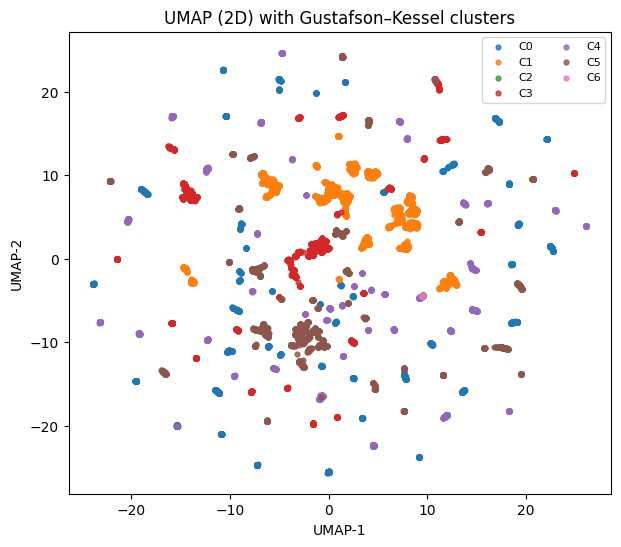

In [24]:
# pip install umap-learn
import numpy as np, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import umap.umap_ as umap

# 0) rows & matrix (NO target leakage)
feat = feature_list
Xsrc = df[feat]
mask = Xsrc.notnull().all(axis=1) & np.isfinite(Xsrc.values).all(axis=1)
idx  = Xsrc.index[mask]
X0   = Xsrc.loc[idx].values

# 1) sensible prep (stabilize & denoise)
X = StandardScaler().fit_transform(X0)
X = PowerTransformer(method="yeo-johnson").fit_transform(X)
X = PCA(n_components=min(50, X.shape[1]), random_state=42).fit_transform(X)

# 2) UMAP embeddings
emb2 = umap.UMAP(n_components=2,  n_neighbors=30, min_dist=0.1, random_state=42).fit_transform(X)
embD = umap.UMAP(n_components=10, n_neighbors=30, min_dist=0.0, random_state=42).fit_transform(X)

# 3) Gustafson–Kessel clustering on UMAP 10D embedding
# (you must have the gk_fuzzy() function defined earlier)
n_clusters = 7        # adjust if needed
m = 2.0 #so 
centers, U, covs, D, fpc = gk_fuzzy(embD, c=n_clusters, m=m, maxiter=300, tol=1e-5, reg=1e-6, random_state=42)
labels = U.argmax(axis=0)
conf   = U.max(axis=0)

# 4) Write back + quality metrics
df.loc[idx, "UMAP_GK_Label"] = labels
df.loc[idx, "UMAP_GK_Conf"]  = conf
sil = silhouette_score(embD, labels) if len(set(labels)) > 1 else np.nan
print(f"GK FPC={fpc:.3f}  Silhouette(embD)={sil:.3f}  sizes=", np.bincount(labels))

# Optional: summary if you have a target column like 'Score'
if "Score" in df.columns:
    summary = (
        df.loc[idx].groupby("UMAP_GK_Label")["Score"]
        .agg(["mean", "median", "count"])
        .sort_values("mean", ascending=False)
    )
    print("\nScore by UMAP-GK cluster:\n", summary)

# 5) Visualize GK clusters on 2D UMAP
plt.figure(figsize=(7,6))
for c in sorted(set(labels)):
    msk = labels == c
    plt.scatter(emb2[msk,0], emb2[msk,1], s=12, alpha=0.8, label=f"C{c}")
plt.title("UMAP (2D) with Gustafson–Kessel clusters")
plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2")
plt.legend(ncol=2, fontsize=8)
plt.show()


embdedded data tsk


In [25]:
import umap, sklearn
from umap import UMAP

print("umap:", umap.__version__)
print("scikit-learn:", sklearn.__version__)


umap: 0.5.5
scikit-learn: 1.5.2


In [26]:


# --- A2. Scale (UMAP likes standardized input) ---
scaler = StandardScaler()
Xtr_s = scaler.fit_transform(Xtr)
Xte_s = scaler.transform(Xte)

# --- A3. Fit UMAP on train, transform both ---
umap_model = UMAP(
    n_components=2,     # change to 3 or more if you want
    n_neighbors=15,
    min_dist=0.1,
    metric="euclidean",
    random_state=42
)
Ztr = umap_model.fit_transform(Xtr_s)
Zte = umap_model.transform(Xte_s)

# Embedded features to use everywhere below
Xtr_emb, Xte_emb = Ztr, Zte

print("Z shapes:", Xtr_emb.shape, Xte_emb.shape)


c:\Users\kaliv\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\kaliv\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
c:\Users\kaliv\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


Z shapes: (11479, 2) (2870, 2)


In [27]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# === 0) Data: pick valid rows and standardize ===
feature_cols = feature_list
X_src = df[feature_cols]
mask = X_src.notnull().all(axis=1) & np.isfinite(X_src.values).all(axis=1)
idx = X_src.index[mask]
X = StandardScaler().fit_transform(X_src.loc[idx].values)  # GK works best with scaled data
N, P = X.shape

# === 1) GK (Gustafson–Kessel) fuzzy clustering ===
def gk_fuzzy(X, c, m=2.0, maxiter=200, tol=1e-5, reg=1e-6, random_state=42):
    """
    X: (N,P) standardized data
    c: number of clusters
    m: fuzzifier (>1)
    Returns: centers (c,P), memberships U (c,N), covariances list length c, distances (c,N), fpc
    """
    rng = np.random.default_rng(random_state)
    N, P = X.shape

    # init memberships uniformly at random then normalize columns
    U = rng.random((c, N)) + 1e-8
    U /= U.sum(axis=0, keepdims=True)

    prev_U = U.copy()
    for it in range(maxiter):
        Um = U ** m                                     # (c,N)

        # centers v_k
        denom = Um.sum(axis=1, keepdims=True)          # (c,1)
        V = (Um @ X) / denom                            # (c,P)

        # covariances C_k and adaptive metric A_k
        A_list, C_list = [], []
        for k in range(c):
            diff = X - V[k]                             # (N,P)
            # weighted covariance
            Sk = (Um[k][:, None] * diff).T @ diff / denom[k, 0]   # (P,P)
            # regularize for stability
            Sk += reg * np.eye(P)
            # GK uses A_k = det(Sk)^(1/P) * inv(Sk)  (volume constraint det(A_k)=1)
            det = np.linalg.det(Sk)
            det = max(det, 1e-12)
            Ak = (det ** (1.0 / P)) * np.linalg.inv(Sk)
            A_list.append(Ak)
            C_list.append(Sk)

        # distances d_{ki}^2 = (x_i - v_k)^T A_k (x_i - v_k)
        D = np.empty((c, N))
        for k in range(c):
            diff = X - V[k]
            D[k] = np.einsum('ij,ij->i', diff @ A_list[k], diff) + 1e-12  # avoid zeros

        # update memberships
        # handle exact zeros by hard-assigning those points to the closest cluster
        zero_mask = (D <= 1e-20)
        if zero_mask.any():
            U[:] = 0.0
            closest = np.argmin(D, axis=0)
            U[closest, np.arange(N)] = 1.0
        else:
            power = 1.0 / (m - 1.0)
            inv = D ** (-power)                 # (c,N)
            U = inv / inv.sum(axis=0, keepdims=True)

        # check convergence (change in U)
        delta = np.linalg.norm(U - prev_U) / (np.linalg.norm(prev_U) + 1e-12)
        if delta < tol:
            break
        prev_U = U.copy()

    fpc = (U ** 2).sum() / N  # fuzzy partition coefficient (higher is crisper)
    return V, U, C_list, D, fpc

# === 2) Run GK ===
n_clusters = 7    # choose how many groups you want
m = 2.0
centers, U, covs, D, fpc = gk_fuzzy(Xtr_emb, c=n_clusters, m=m, maxiter=300, tol=1e-5, reg=1e-6, random_state=42)

In [28]:
sigmas = np.zeros((n_clusters, Xtr_emb.shape[1]))
for i in range(n_clusters):
    sigmas[i, :] = np.sqrt(np.diag(covs[i]) + 1e-8)

print(f"Sigmas shape: {sigmas.shape}")


Sigmas shape: (7, 2)


In [29]:
# Build model
model = TSK(n_inputs=Xtr_emb.shape[1], n_rules=n_clusters, centers=centers, sigmas=sigmas)

Xtr = torch.tensor(Xtr_emb, dtype=torch.float32)
ytr = torch.tensor(ytr, dtype=torch.float32)
Xte = torch.tensor(Xte_emb, dtype=torch.float32)
yte = torch.tensor(yte, dtype=torch.float32)

C:\Users\kaliv\AppData\Local\Temp\ipykernel_5676\3247704221.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ytr = torch.tensor(ytr, dtype=torch.float32)
C:\Users\kaliv\AppData\Local\Temp\ipykernel_5676\3247704221.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  yte = torch.tensor(yte, dtype=torch.float32)


In [30]:
train_ls(model, Xtr, ytr.reshape(-1,1))

y_pred, _, _=model(Xte)

#print(f'ACC:{accuracy_score(yte.detach().numpy(),y_pred.detach().numpy()>0.5)}') #classification
print(f'MSE:{mean_squared_error(yte.detach().numpy(),y_pred.detach().numpy())}') #regression

def vaf(y_true, y_pred):
    # Convert tensors to NumPy if needed
    if isinstance(y_true, torch.Tensor):
        y_true = y_true.detach().cpu().numpy()
    if isinstance(y_pred, torch.Tensor):
        y_pred = y_pred.detach().cpu().numpy()
    
    y_true_var = np.var(y_true)    
    return (1 - np.var(y_true - y_pred) / y_true_var) * 100

# Example usage
print(f"VAF = {vaf(yte, y_pred):.2f}%")

MSE:9.995038032531738
VAF = 17.61%


In [31]:
# Training with ANFIS:
train_hybrid_anfis(model, Xtr, ytr.reshape(-1,1))

y_pred, _, _=model(Xte)

#print(f'ACC:{accuracy_score(yte.detach().numpy(),y_pred.detach().numpy()>0.5)}') #classification
print(f'MSE:{mean_squared_error(yte.detach().numpy(),y_pred.detach().numpy())}') #regression

def vaf(y_true, y_pred):
    # Convert tensors to NumPy if needed
    if isinstance(y_true, torch.Tensor):
        y_true = y_true.detach().cpu().numpy()
    if isinstance(y_pred, torch.Tensor):
        y_pred = y_pred.detach().cpu().numpy()
    
    y_true_var = np.var(y_true)    
    return (1 - np.var(y_true - y_pred) / y_true_var) * 100

# Example usage
print(f"VAF = {vaf(yte, y_pred):.2f}%")

tensor(9.5672, grad_fn=<MseLossBackward0>)
tensor(9.5672, grad_fn=<MseLossBackward0>)
tensor(9.5671, grad_fn=<MseLossBackward0>)
tensor(9.5670, grad_fn=<MseLossBackward0>)
tensor(9.5669, grad_fn=<MseLossBackward0>)
tensor(9.5668, grad_fn=<MseLossBackward0>)
tensor(9.5668, grad_fn=<MseLossBackward0>)
tensor(9.5667, grad_fn=<MseLossBackward0>)
tensor(9.5666, grad_fn=<MseLossBackward0>)
tensor(9.5665, grad_fn=<MseLossBackward0>)
tensor(9.5664, grad_fn=<MseLossBackward0>)
tensor(9.5664, grad_fn=<MseLossBackward0>)
tensor(9.5663, grad_fn=<MseLossBackward0>)
tensor(9.5662, grad_fn=<MseLossBackward0>)
tensor(9.5661, grad_fn=<MseLossBackward0>)
tensor(9.5660, grad_fn=<MseLossBackward0>)
tensor(9.5659, grad_fn=<MseLossBackward0>)
tensor(9.5659, grad_fn=<MseLossBackward0>)
tensor(9.5658, grad_fn=<MseLossBackward0>)
tensor(9.5657, grad_fn=<MseLossBackward0>)
tensor(9.5656, grad_fn=<MseLossBackward0>)
tensor(9.5655, grad_fn=<MseLossBackward0>)
tensor(9.5655, grad_fn=<MseLossBackward0>)
tensor(9.56

MSE: 9.99233627319336
R² Score: 0.17597579956054688


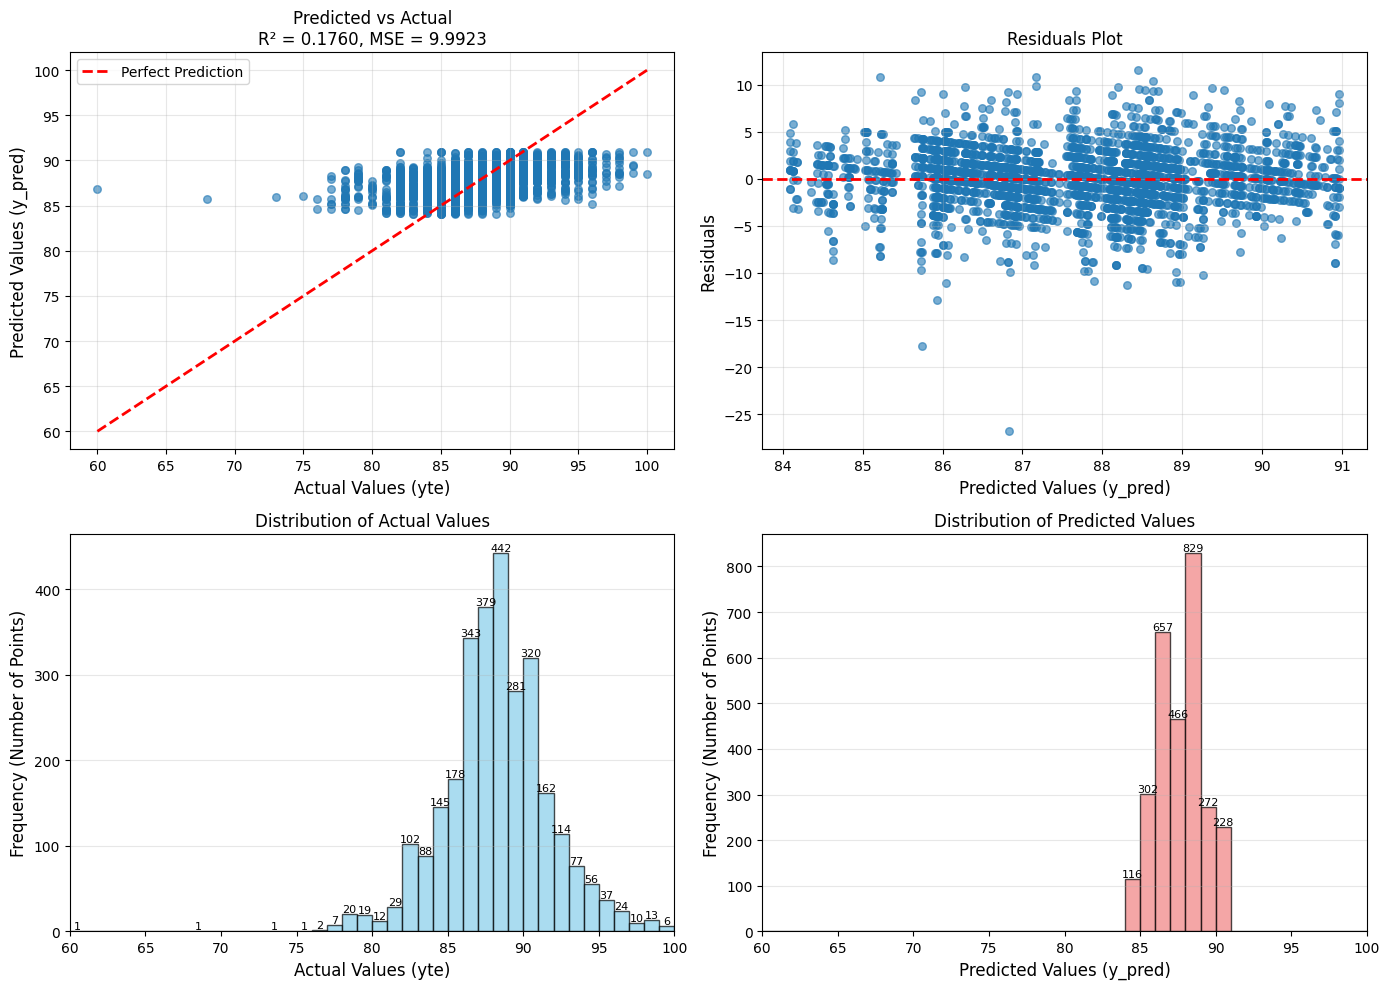

In [32]:

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Convert to numpy and flatten
y_actual = yte.detach().numpy().flatten()
y_predicted = y_pred.detach().numpy().flatten()

# Calculate metrics
mse = mean_squared_error(y_actual, y_predicted)
r2 = r2_score(y_actual, y_predicted)

print(f'MSE: {mse}')
print(f'R² Score: {r2}')

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Scatter plot of Predicted vs Actual
ax1 = axes[0, 0]
ax1.scatter(y_actual, y_predicted, alpha=0.6, s=30)
# Add perfect prediction line
min_val = min(y_actual.min(), y_predicted.min())
max_val = max(y_actual.max(), y_predicted.max())
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Values (yte)', fontsize=12)
ax1.set_ylabel('Predicted Values (y_pred)', fontsize=12)
ax1.set_title(f'Predicted vs Actual\nR² = {r2:.4f}, MSE = {mse:.4f}', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Residuals plot
ax2 = axes[0, 1]
residuals = y_actual - y_predicted
ax2.scatter(y_predicted, residuals, alpha=0.6, s=30)
ax2.axhline(y=0, color='r', linestyle='--', lw=2)
ax2.set_xlabel('Predicted Values (y_pred)', fontsize=12)
ax2.set_ylabel('Residuals', fontsize=12)
ax2.set_title('Residuals Plot', fontsize=12)
ax2.grid(True, alpha=0.3)

# Plot 3: Histogram of actual values with counts on bars
ax3 = axes[1, 0]
# Create bins for each integer value
min_val = min(y_actual.min(), y_predicted.min())
max_val = max(y_actual.max(), y_predicted.max())
bins = np.arange(np.floor(min_val), np.ceil(max_val) + 1, 1)  # Bins of size 1 (each integer)
counts, bin_edges, patches = ax3.hist(y_actual.flatten(), bins=bins, edgecolor='black', alpha=0.7, color='skyblue')
# Add count labels on top of each bar
for count, patch in zip(counts, patches):
    if count > 0:  # Only show label if there are points
        height = patch.get_height()
        ax3.text(patch.get_x() + patch.get_width()/2., height,
                f'{int(count)}', ha='center', va='bottom', fontsize=8)
ax3.set_xlabel('Actual Values (yte)', fontsize=12)
ax3.set_ylabel('Frequency (Number of Points)', fontsize=12)
ax3.set_title('Distribution of Actual Values', fontsize=12)
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Histogram of predicted values with counts on bars
ax4 = axes[1, 1]
counts, bin_edges, patches = ax4.hist(y_predicted.flatten(), bins=bins, edgecolor='black', alpha=0.7, color='lightcoral')
# Add count labels on top of each bar
for count, patch in zip(counts, patches):
    if count > 0:  # Only show label if there are points
        height = patch.get_height()
        ax4.text(patch.get_x() + patch.get_width()/2., height,
                f'{int(count)}', ha='center', va='bottom', fontsize=8)
ax4.set_xlabel('Predicted Values (y_pred)', fontsize=12)
ax4.set_ylabel('Frequency (Number of Points)', fontsize=12)
ax4.set_title('Distribution of Predicted Values', fontsize=12)
ax4.grid(True, alpha=0.3, axis='y')

# Set the same x-axis limits for both histograms
ax3.set_xlim(np.floor(min_val), np.ceil(max_val))
ax4.set_xlim(np.floor(min_val), np.ceil(max_val))

plt.tight_layout()
plt.show()

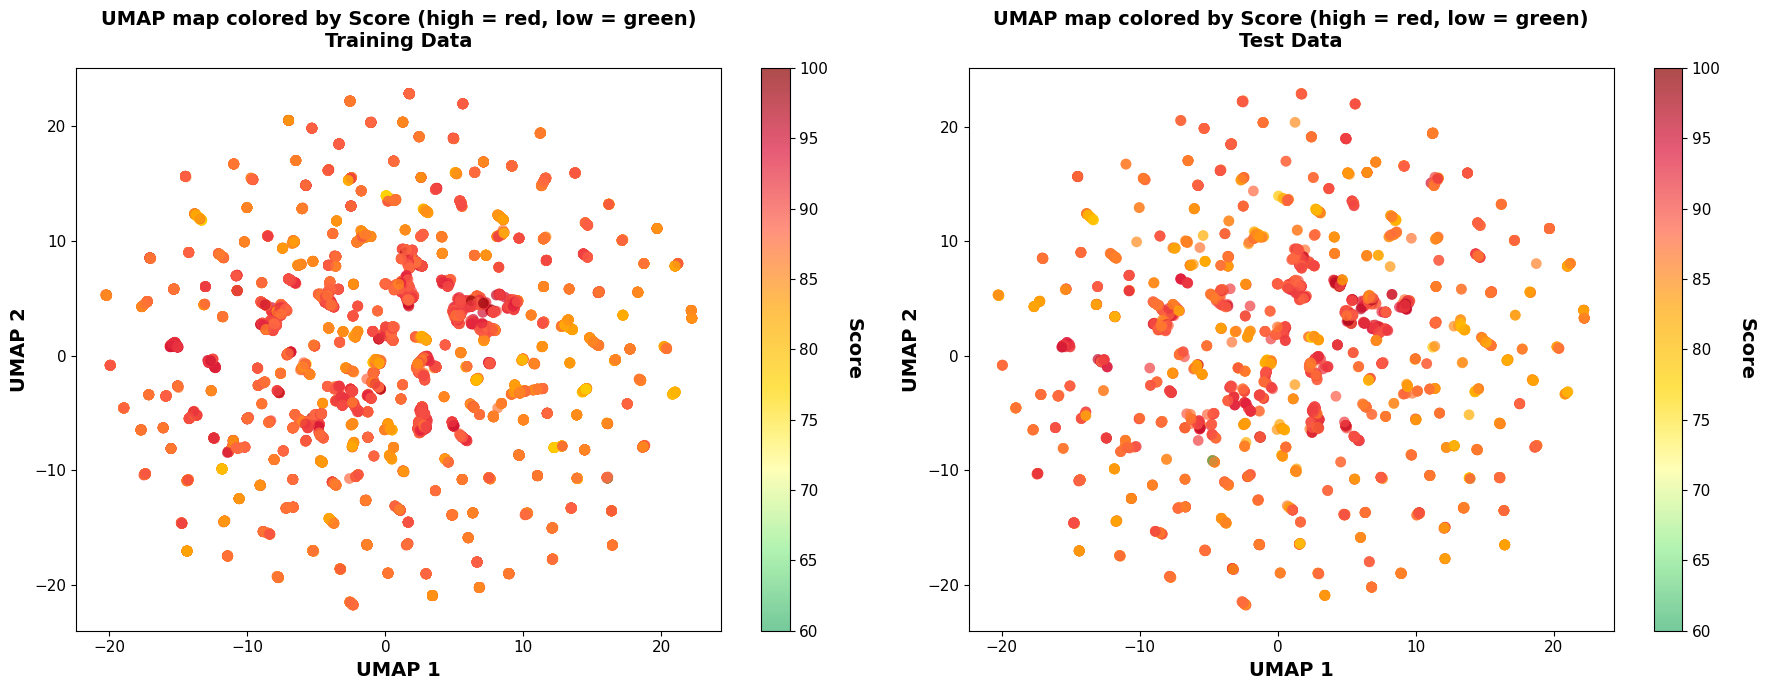

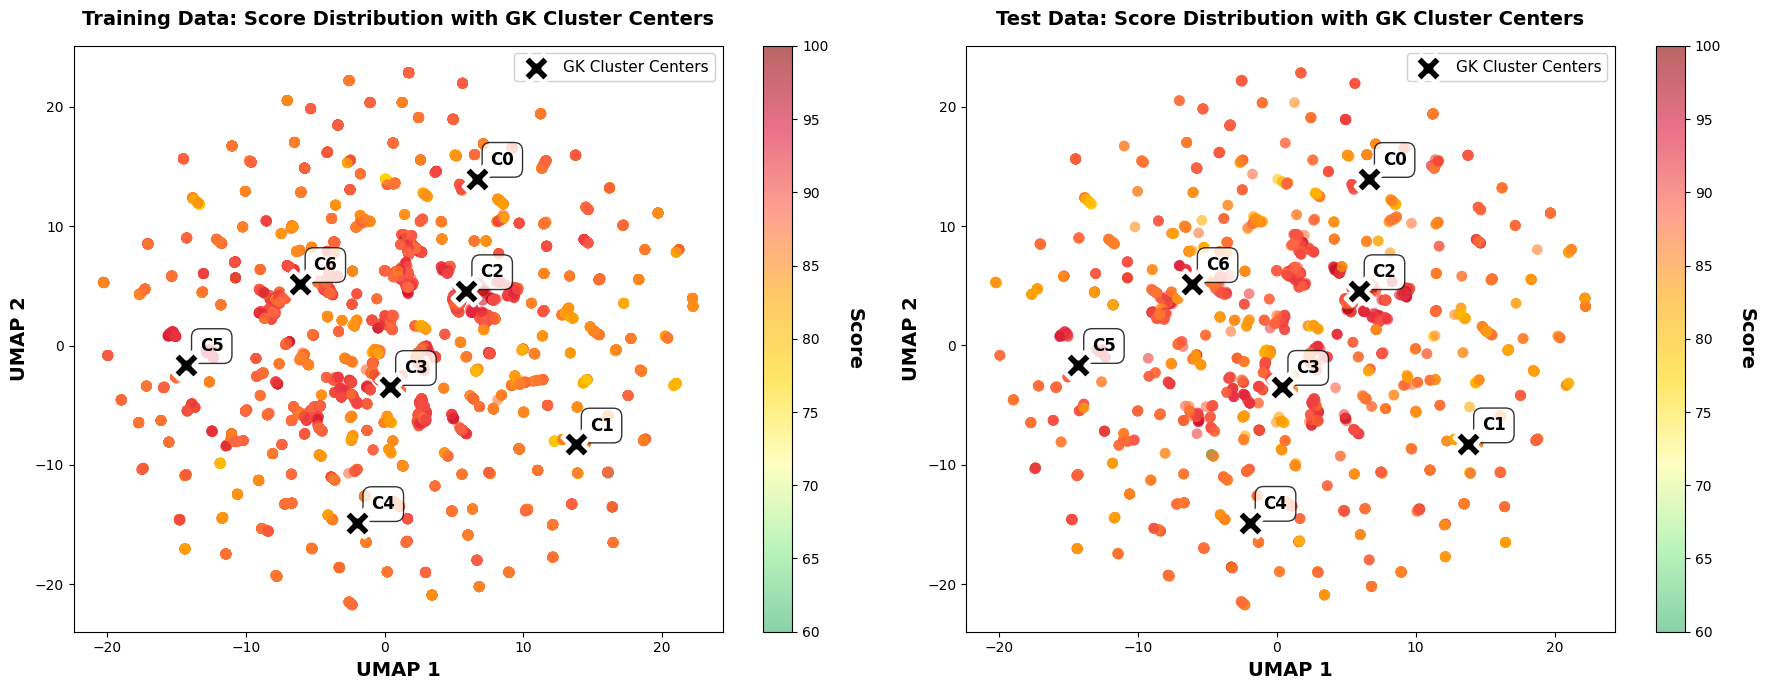


SCORE STATISTICS BY GK CLUSTER

Cluster 0:
  Samples: 1382
  Score range: [69.00, 96.00]
  Mean score: 86.76 ± 3.06
  Median score: 87.00

Cluster 1:
  Samples: 1213
  Score range: [60.00, 97.00]
  Mean score: 85.59 ± 3.42
  Median score: 86.00

Cluster 2:
  Samples: 2424
  Score range: [60.00, 100.00]
  Mean score: 89.38 ± 3.44
  Median score: 89.00

Cluster 3:
  Samples: 2129
  Score range: [75.00, 100.00]
  Mean score: 88.43 ± 3.33
  Median score: 89.00

Cluster 4:
  Samples: 1235
  Score range: [70.00, 98.00]
  Mean score: 86.55 ± 2.42
  Median score: 87.00

Cluster 5:
  Samples: 1424
  Score range: [77.00, 100.00]
  Mean score: 88.19 ± 3.73
  Median score: 88.00

Cluster 6:
  Samples: 1672
  Score range: [72.00, 100.00]
  Mean score: 87.82 ± 2.99
  Median score: 88.00


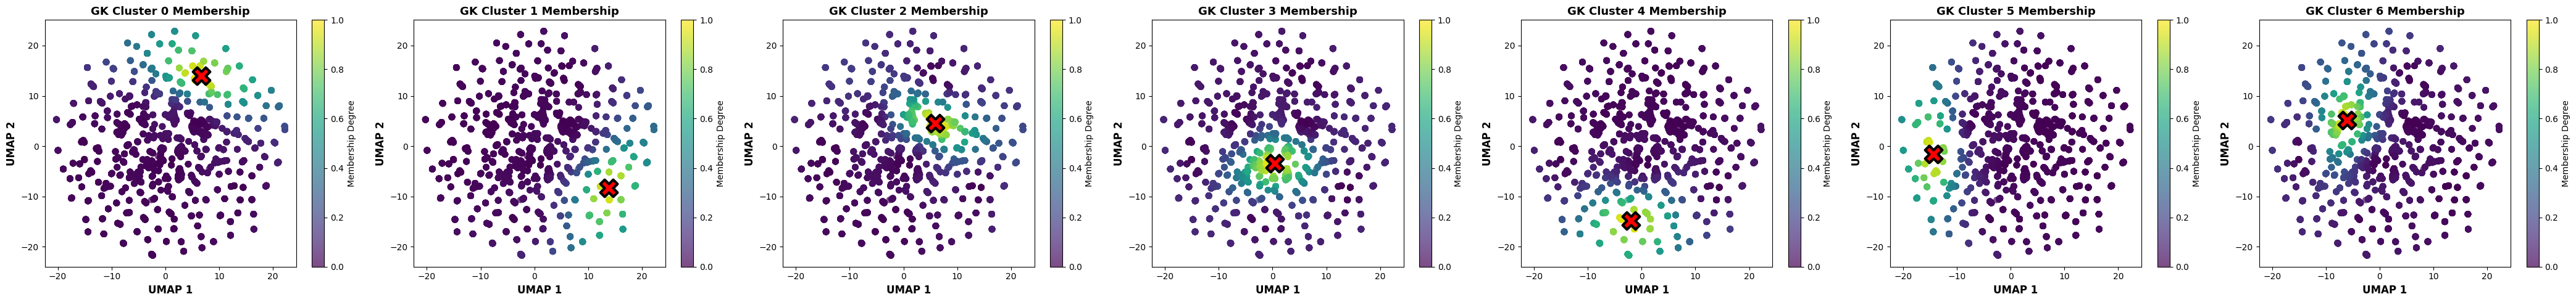

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Assuming you have:
# Xtr_emb, Xte_emb (UMAP embeddings)
# ytr, yte (target values - scores)
# U (fuzzy membership matrix from GK)
# centers (cluster centers from GK)
# n_clusters

# ============================================================================
# 1. UMAP colored by target score (like PCA plot)
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Create custom colormap: green (low) -> yellow -> orange -> red (high)
colors_list = ['#3CB371', '#90EE90', '#FFFF99', '#FFD700', '#FFA500', '#FF6347', '#DC143C', '#8B0000']
n_bins = 256
cmap = LinearSegmentedColormap.from_list('score_cmap', colors_list, N=n_bins)

# Left plot: Training data colored by score
ax1 = axes[0]
scatter1 = ax1.scatter(Xtr_emb[:, 0], Xtr_emb[:, 1], 
                       c=ytr, cmap=cmap,
                       s=60, alpha=0.7, edgecolors='none')

cbar1 = plt.colorbar(scatter1, ax=ax1)
cbar1.set_label('Score', fontsize=14, fontweight='bold', rotation=270, labelpad=25)
cbar1.ax.tick_params(labelsize=11)

ax1.set_xlabel('UMAP 1', fontsize=14, fontweight='bold')
ax1.set_ylabel('UMAP 2', fontsize=14, fontweight='bold')
ax1.set_title('UMAP map colored by Score (high = red, low = green)\nTraining Data', 
              fontsize=14, fontweight='bold', pad=15)
ax1.tick_params(labelsize=11)
ax1.set_facecolor('white')
ax1.grid(False)

# Right plot: Test data colored by score
ax2 = axes[1]
scatter2 = ax2.scatter(Xte_emb[:, 0], Xte_emb[:, 1], 
                       c=yte, cmap=cmap,
                       s=60, alpha=0.7, edgecolors='none')

cbar2 = plt.colorbar(scatter2, ax=ax2)
cbar2.set_label('Score', fontsize=14, fontweight='bold', rotation=270, labelpad=25)
cbar2.ax.tick_params(labelsize=11)

ax2.set_xlabel('UMAP 1', fontsize=14, fontweight='bold')
ax2.set_ylabel('UMAP 2', fontsize=14, fontweight='bold')
ax2.set_title('UMAP map colored by Score (high = red, low = green)\nTest Data', 
              fontsize=14, fontweight='bold', pad=15)
ax2.tick_params(labelsize=11)
ax2.set_facecolor('white')
ax2.grid(False)

plt.tight_layout()
plt.show()

# ============================================================================
# 2. UMAP with GK cluster centers overlay
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Left: Training with cluster overlay
ax1 = axes[0]
scatter1 = ax1.scatter(Xtr_emb[:, 0], Xtr_emb[:, 1], 
                       c=ytr, cmap=cmap,
                       s=60, alpha=0.6, edgecolors='none')

# Overlay cluster centers
ax1.scatter(centers[:, 0], centers[:, 1], 
           c='black', marker='X', s=400, 
           edgecolors='white', linewidth=3,
           label='GK Cluster Centers', zorder=5)

# Add cluster labels
for i in range(n_clusters):
    ax1.annotate(f'C{i}', 
                xy=(centers[i, 0], centers[i, 1]),
                xytext=(10, 10), textcoords='offset points',
                fontsize=12, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='white', 
                         edgecolor='black', alpha=0.8))

cbar1 = plt.colorbar(scatter1, ax=ax1)
cbar1.set_label('Score', fontsize=14, fontweight='bold', rotation=270, labelpad=25)

ax1.set_xlabel('UMAP 1', fontsize=14, fontweight='bold')
ax1.set_ylabel('UMAP 2', fontsize=14, fontweight='bold')
ax1.set_title('Training Data: Score Distribution with GK Cluster Centers', 
              fontsize=14, fontweight='bold', pad=15)
ax1.legend(loc='best', fontsize=11, framealpha=0.9)
ax1.set_facecolor('white')
ax1.grid(False)

# Right: Test with cluster overlay
ax2 = axes[1]
scatter2 = ax2.scatter(Xte_emb[:, 0], Xte_emb[:, 1], 
                       c=yte, cmap=cmap,
                       s=60, alpha=0.6, edgecolors='none')

# Overlay cluster centers
ax2.scatter(centers[:, 0], centers[:, 1], 
           c='black', marker='X', s=400, 
           edgecolors='white', linewidth=3,
           label='GK Cluster Centers', zorder=5)

# Add cluster labels
for i in range(n_clusters):
    ax2.annotate(f'C{i}', 
                xy=(centers[i, 0], centers[i, 1]),
                xytext=(10, 10), textcoords='offset points',
                fontsize=12, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='white', 
                         edgecolor='black', alpha=0.8))

cbar2 = plt.colorbar(scatter2, ax=ax2)
cbar2.set_label('Score', fontsize=14, fontweight='bold', rotation=270, labelpad=25)

ax2.set_xlabel('UMAP 1', fontsize=14, fontweight='bold')
ax2.set_ylabel('UMAP 2', fontsize=14, fontweight='bold')
ax2.set_title('Test Data: Score Distribution with GK Cluster Centers', 
              fontsize=14, fontweight='bold', pad=15)
ax2.legend(loc='best', fontsize=11, framealpha=0.9)
ax2.set_facecolor('white')
ax2.grid(False)

plt.tight_layout()
plt.show()

# ============================================================================
# 3. Print score statistics per GK cluster
# ============================================================================

print("\n" + "="*60)
print("SCORE STATISTICS BY GK CLUSTER")
print("="*60)

# Get hard cluster assignments
cluster_labels = np.argmax(U, axis=0)

for i in range(n_clusters):
    mask = cluster_labels == i
    cluster_scores = ytr[mask]
    
    print(f"\nCluster {i}:")
    print(f"  Samples: {np.sum(mask)}")
    print(f"  Score range: [{cluster_scores.min():.2f}, {cluster_scores.max():.2f}]")
    print(f"  Mean score: {cluster_scores.mean():.2f} ± {cluster_scores.std():.2f}")
    print(f"  Median score: {np.median(cluster_scores):.2f}")

# ============================================================================
# 4. Optional: Plot cluster membership strength
# ============================================================================

fig, axes = plt.subplots(1, n_clusters, figsize=(6*n_clusters, 5))
if n_clusters == 1:
    axes = [axes]

for i in range(n_clusters):
    ax = axes[i]
    
    # Color by membership strength to this cluster
    scatter = ax.scatter(Xtr_emb[:, 0], Xtr_emb[:, 1],
                        c=U[i, :], cmap='viridis',
                        s=60, alpha=0.7, edgecolors='none',
                        vmin=0, vmax=1)
    
    # Mark the center
    ax.scatter(centers[i, 0], centers[i, 1],
              c='red', marker='X', s=400,
              edgecolors='black', linewidth=3, zorder=5)
    
    plt.colorbar(scatter, ax=ax, label='Membership Degree')
    
    ax.set_xlabel('UMAP 1', fontsize=12, fontweight='bold')
    ax.set_ylabel('UMAP 2', fontsize=12, fontweight='bold')
    ax.set_title(f'GK Cluster {i} Membership', fontsize=13, fontweight='bold')
    ax.set_facecolor('white')
    ax.grid(False)

plt.tight_layout()
plt.show()

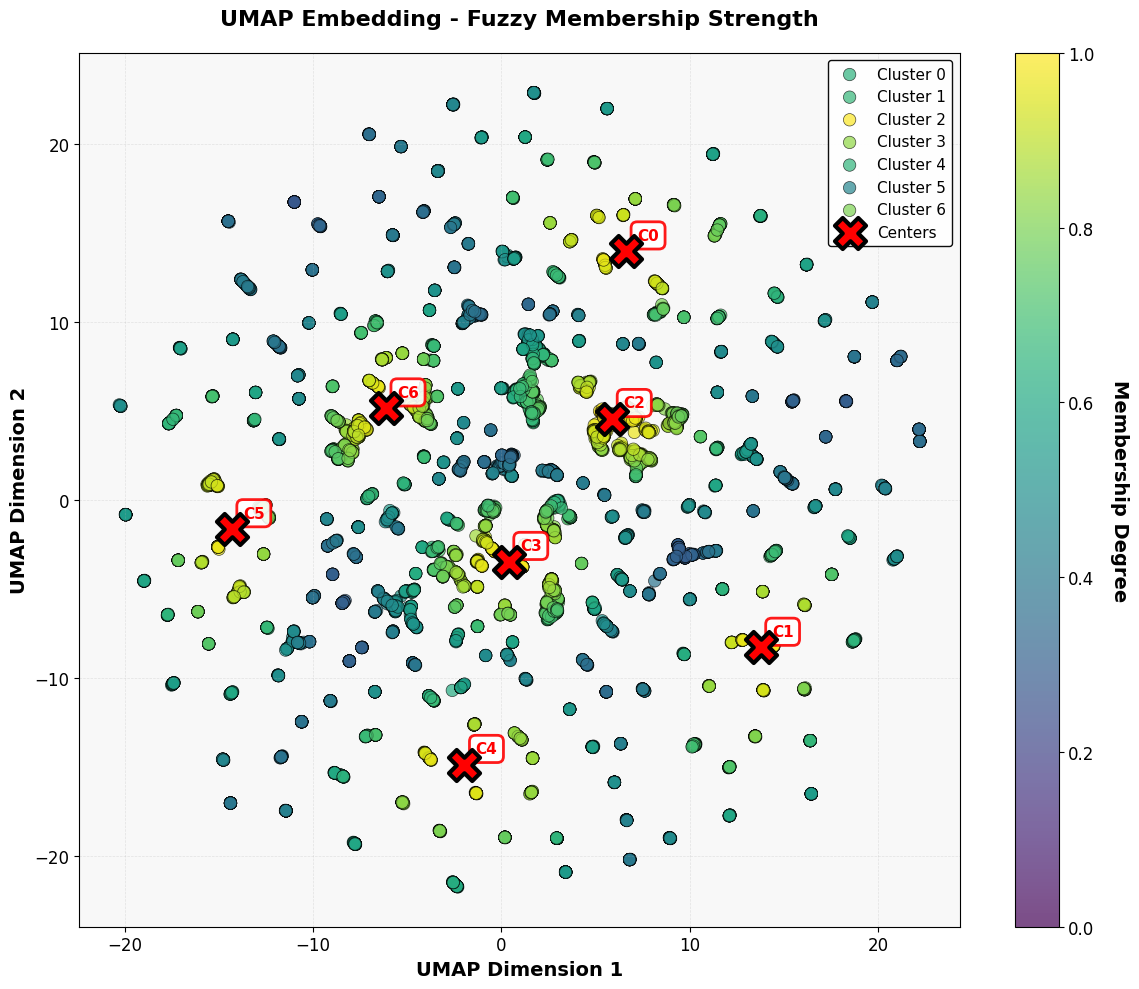


GK CLUSTER STATISTICS

Cluster 0:
  Samples: 1382 (12.0%)
  Avg membership: 0.629
  Center: [6.63, 13.97]

Cluster 1:
  Samples: 1213 (10.6%)
  Avg membership: 0.623
  Center: [13.77, -8.28]

Cluster 2:
  Samples: 2424 (21.1%)
  Avg membership: 0.733
  Center: [5.89, 4.56]

Cluster 3:
  Samples: 2129 (18.5%)
  Avg membership: 0.640
  Center: [0.40, -3.46]

Cluster 4:
  Samples: 1235 (10.8%)
  Avg membership: 0.640
  Center: [-1.95, -14.86]

Cluster 5:
  Samples: 1424 (12.4%)
  Avg membership: 0.651
  Center: [-14.31, -1.63]

Cluster 6:
  Samples: 1672 (14.6%)
  Avg membership: 0.641
  Center: [-6.12, 5.16]


In [34]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Assuming you have:
# Xtr_emb (UMAP embeddings)
# U (fuzzy membership matrix from GK clustering)
# centers (cluster centers)
# n_clusters (should be 7)

# Get the cluster with maximum membership for each point
cluster_labels = np.argmax(U, axis=0)

# Get membership strength (max membership value)
membership_strength = np.max(U, axis=0)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 10))

# Create colormap for clusters
colors = cm.tab10(np.linspace(0, 1, n_clusters))

# Plot each cluster with color based on membership strength
for i in range(n_clusters):
    mask = cluster_labels == i
    
    # Plot points belonging to this cluster
    # Color intensity based on membership strength
    scatter = ax.scatter(Xtr_emb[mask, 0], Xtr_emb[mask, 1],
                        c=membership_strength[mask], 
                        cmap='viridis',
                        s=80, alpha=0.7, edgecolors='black', linewidth=0.5,
                        vmin=0, vmax=1,
                        label=f'Cluster {i}')

# Add colorbar for membership degree
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Membership Degree', fontsize=14, fontweight='bold', rotation=270, labelpad=25)
cbar.ax.tick_params(labelsize=12)

# Plot cluster centers
ax.scatter(centers[:, 0], centers[:, 1],
          c='red', marker='X', s=500,
          edgecolors='black', linewidth=3,
          label='Centers', zorder=10)

# Add cluster labels near centers
for i in range(n_clusters):
    ax.annotate(f'C{i}',
                xy=(centers[i, 0], centers[i, 1]),
                xytext=(8, 8), textcoords='offset points',
                fontsize=11, fontweight='bold',
                color='red',
                bbox=dict(boxstyle='round,pad=0.4', facecolor='white', 
                         edgecolor='red', alpha=0.9, linewidth=2))

# Styling
ax.set_xlabel('UMAP Dimension 1', fontsize=14, fontweight='bold')
ax.set_ylabel('UMAP Dimension 2', fontsize=14, fontweight='bold')
ax.set_title('UMAP Embedding - Fuzzy Membership Strength', fontsize=16, fontweight='bold', pad=20)
ax.tick_params(labelsize=12)
ax.legend(loc='upper right', fontsize=11, framealpha=0.95, edgecolor='black', 
          bbox_to_anchor=(1.0, 1.0))
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
ax.set_facecolor('#f8f8f8')

plt.tight_layout()
plt.show()

# Print cluster statistics
print("\n" + "="*60)
print("GK CLUSTER STATISTICS")
print("="*60)

for i in range(n_clusters):
    mask = cluster_labels == i
    n_samples = np.sum(mask)
    avg_membership = membership_strength[mask].mean()
    
    print(f"\nCluster {i}:")
    print(f"  Samples: {n_samples} ({100*n_samples/len(cluster_labels):.1f}%)")
    print(f"  Avg membership: {avg_membership:.3f}")
    print(f"  Center: [{centers[i, 0]:.2f}, {centers[i, 1]:.2f}]")